# Question 1 

This notebook presents the Exploratory Data Analysis(EDA) of the data provided by AB Inbev - BEES as part of the selection process for the Data Scientist position. The objective of this challenge is to structure the data, understand its characteristics, and finally, predict the number of **remaining days with orders** for each user.

### 1. Exploratory Data Analysis (EDA)

First, the necessary libraries are imported and the data is read in Parquet format.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

#### Display each datasets

In [8]:
august_missing_order = pd.read_parquet('data_files_challenge/august_with_missing_order_days.parquet')
historical_orders = pd.read_parquet('data_files_challenge/historical_orders.parquet')
august_total_sales= pd.read_parquet('data_files_challenge/august_total_sales.parquet')

print("Information about each datasets")
print("\n--- August Missing Order ---")
print(august_missing_order.head())
print("\n--- Historical Orders ---")
print(historical_orders.head())
print("\n--- August Total Sales ---")
print(august_total_sales.head())

Information about each datasets

--- August Missing Order ---
       account_id  order_date  transaction_amount
0  BR_09532176632  2022-08-03               11.16
1  BR_09532176632  2022-08-03               32.52
2  BR_09532176632  2022-08-03               24.90
3  BR_09532176632  2022-08-03               28.50
4  BR_09532176632  2022-08-03               11.16

--- Historical Orders ---
          account_id  order_date  transaction_amount
0  BR_09607801000194  2021-08-28             11011.2
1  BR_09607801000194  2021-08-28             13764.0
2  BR_09607801000194  2021-08-28             11011.2
3  BR_09607801000194  2021-08-28             11011.2
4  BR_09607801000194  2021-08-28             13764.0

--- August Total Sales ---
       account_id  total_transaction_amount_august
0  BR_00000343803                           309.99
1  BR_00001415930                           874.98
2  BR_00001760106                         11976.70
3  BR_00002485176                           511.48
4  BR_0000

#### Information about each dataset

In [3]:

print("Information about each datasets")
print("\n--- August Missing Order ---")
print(august_missing_order.info())
print("\n--- Historical Orders ---")
print(historical_orders.info())
print("\n--- August Total Sales ---")
print(august_total_sales.info())

Information about each datasets

--- August Missing Order ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317735 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   account_id          317735 non-null  object 
 1   order_date          304297 non-null  object 
 2   transaction_amount  304297 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB
None

--- Historical Orders ---
<class 'pandas.core.frame.DataFrame'>
Index: 8596877 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype  
---  ------              -----  
 0   account_id          object 
 1   order_date          object 
 2   transaction_amount  float64
dtypes: float64(1), object(2)
memory usage: 262.4+ MB
None

--- August Total Sales ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                

#### Description of each dataset

In [4]:

print("Information about each datasets")
print("\n--- August Missing Order ---")
print(august_missing_order.describe())
print("\n--- Historical Orders ---")
print(historical_orders.info())
print("\n--- August Total Sales ---")
print(august_total_sales.info())

Information about each datasets

--- August Missing Order ---
       transaction_amount
count       304297.000000
mean           281.339536
std           1251.632794
min            -99.000000
25%             34.930000
50%             84.000000
75%            205.250000
max         171325.440000

--- Historical Orders ---
<class 'pandas.core.frame.DataFrame'>
Index: 8596877 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype  
---  ------              -----  
 0   account_id          object 
 1   order_date          object 
 2   transaction_amount  float64
dtypes: float64(1), object(2)
memory usage: 262.4+ MB
None

--- August Total Sales ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       32944 non-null  object 
 1   total_transaction_a

Transform dataset `august_with_missing_order_days` and `historical_orders` dates to make them easier to manipulate

In [10]:
august_missing_order['order_date'] = pd.to_datetime(august_missing_order['order_date'])
historical_orders['order_date'] = pd.to_datetime(historical_orders['order_date'])

#### Check the datasets for missing values

In [32]:
print("\n--- Missing values in August Missing Order ---")
print(august_missing_order.isnull().sum())


print("\n--- Missing values in Historical Orders ---")
print(historical_orders.isnull().sum())


print("\n--- Missing values in August Total Sales ---")
print(august_total_sales.isnull().sum())


--- Missing values in August Missing Order ---
account_id                0
order_date            13438
transaction_amount    13438
dtype: int64

--- Missing values in Historical Orders ---
account_id            0
order_date            0
transaction_amount    0
month_year            0
day_of_week           0
dtype: int64

--- Missing values in August Total Sales ---
account_id                         0
total_transaction_amount_august    0
dtype: int64


As stated in the challenge case, `august_with_missing_order_days` is the only dataset that contains missing values, both in the `order_date` and `transaction_amount` columns. This dataset specifically represents the known orders for the month of August for which predictions need to be made. The `historical_orders` and `august_total_sales` datasets do not have any missing values.

#### Historical Orders by Day

With the historical orders data, it is possible to analyze the behavior over time, such as identifying the days and months with the highest order frequency and even estimating how many order days are yet to come.

Below we can see how orders behave over a period of time. But first, it is necessary to know the time period that the data covers

In [33]:
star_date = historical_orders['order_date'].min()
end_date = historical_orders['order_date'].max()
print(f"Period covered in the historical orders dataset from {star_date} to {end_date}")

Period covered in the historical orders dataset from 2021-01-02 00:00:00 to 2022-07-31 00:00:00


#### Statistics for the data from 2021 to 2022 and also find the day with the highest number of orders for each day

In [34]:
orders21 = historical_orders[historical_orders['order_date'].dt.year == 2021]
orders_days_21 = orders21.groupby('order_date').size()

orders22 = historical_orders[historical_orders['order_date'].dt.year == 2022]
orders_days_22 = orders22.groupby('order_date').size()

maxDay21 = orders_days_21.idxmax()
maxOrders21 = orders_days_21.max()

maxDay22 = orders_days_22.idxmax()
maxOrders22 = orders_days_22.max()


info = {
    'Year': ['2021', '2022'],
    'Mean Daily Orders': [orders_days_21.mean(), orders_days_22.mean()],
    'Median Daily Orders': [orders_days_21.median(), orders_days_22.median()],
    'Std Daily Orders': [orders_days_21.std(), orders_days_22.std()],
    'Day with Most Orders': [maxDay21, maxDay22],
    'Most Orders in a Day': [maxOrders21, maxOrders22]
}


info_df = pd.DataFrame(info)
display(info_df)

,Year,Mean Daily Orders,Median Daily Orders,Std Daily Orders,Day with Most Orders,Most Orders in a Day
0,2021,14229.433544,14146.5,6133.776597,2021-10-14,37289
1,2022,19904.737864,18706.5,11916.963395,2022-04-11,45145


With these statistics about the order history, we have a general idea about the orders for each year. In **2021**, the day with the most orders was **October 14th with 37.289 orders**. In **2022**, the day with the most orders was **April 11th with 45,145 orders**.

Observing the mean, median, and standard deviation, overall, 2022 had more daily orders than 2021, with the average number of orders being substantially higher than in 2021.

#### Daily Orders Analysis through Time Series

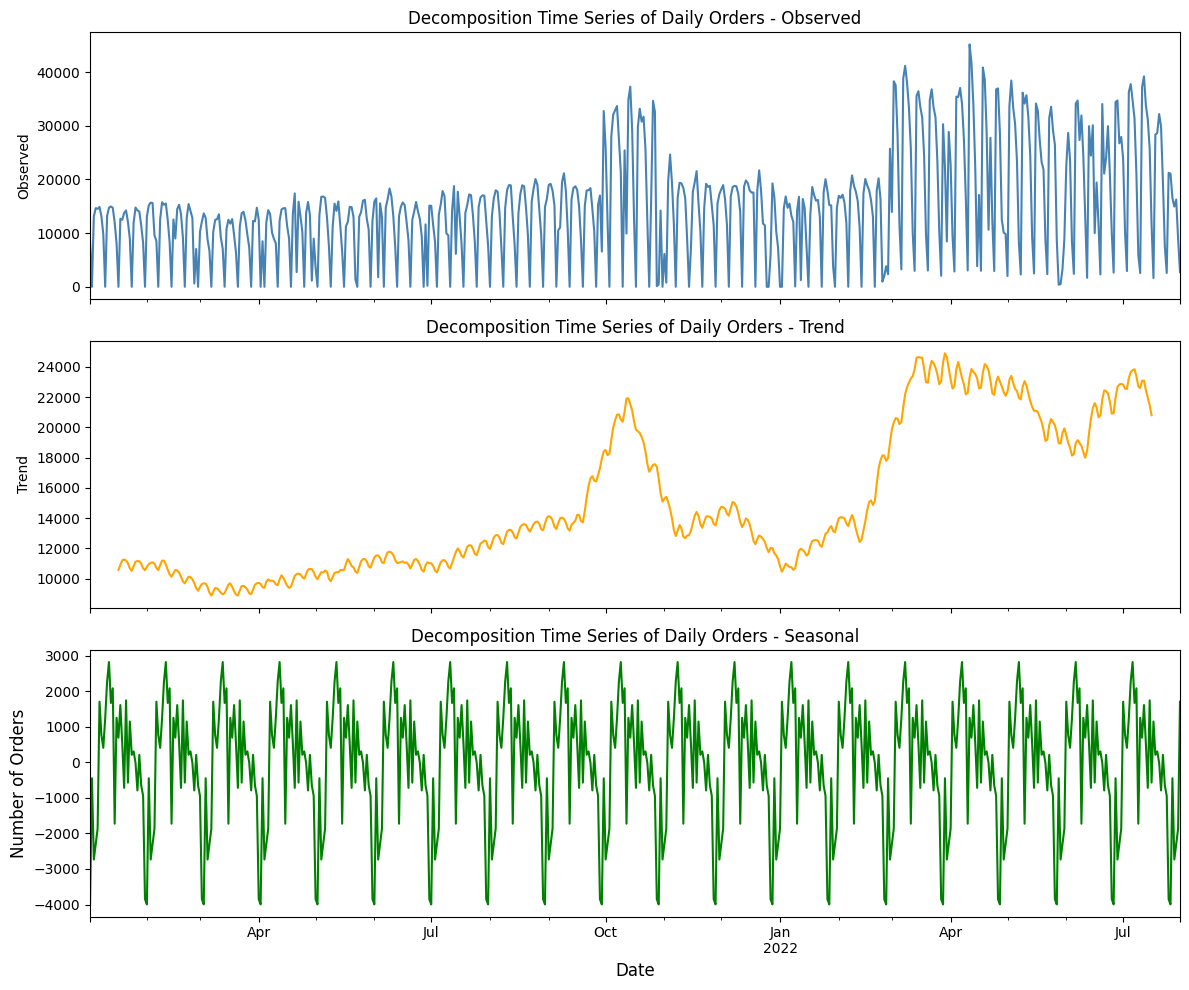

In [31]:
daily_orders = historical_orders.groupby('order_date').size().asfreq('D').fillna(0)
decomposition = seasonal_decompose(daily_orders,model = 'additive', period = 30)

fig, (ax1, ax2, ax3)  = plt.subplots(3,1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=ax1, color = 'steelblue')
ax1.set_ylabel('Observed')
ax1.set_title('Decomposition Time Series of Daily Orders - Observed')
decomposition.trend.plot(ax=ax2, color = 'orange')
ax2.set_ylabel('Trend')
ax2.set_title('Decomposition Time Series of Daily Orders - Trend')
decomposition.seasonal.plot(ax=ax3, color = 'green')
ax3.set_ylabel('Seasonal')
ax3.set_title('Decomposition Time Series of Daily Orders - Seasonal')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Orders', loc='center', fontsize=12)
plt.tight_layout()
plt.show()

This time series chart shows the decomposition of daily orders and consequently the behavior of the three main components of a time series.

The observed chart shows that in October there was a peak in orders, followed by another peak in the period from March to April. The trend chart shows these same trends of order growth in seasonal periods, with a specific peak in October 2021 and another in March 2022.

The seasonal chart reveals patterns that repeat consistently, indicating a monthly purchasing cycle by customers.

#### Orders in August

As the goal is to predict the orders for the month of August, it is also important to analyze the available data.

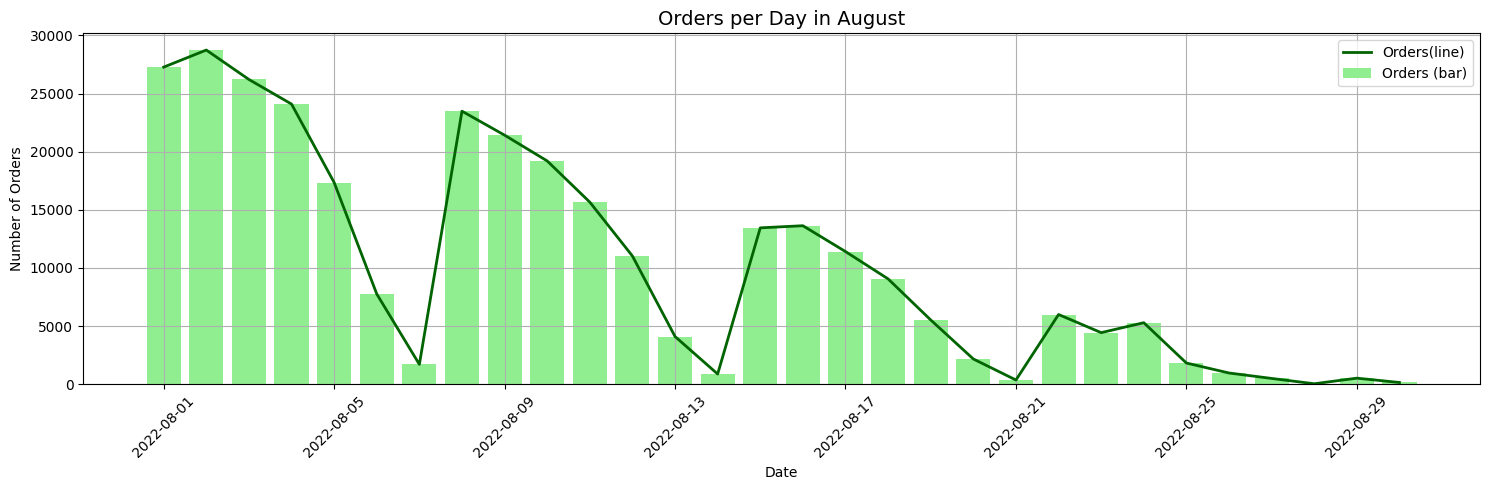

In [22]:
AugustDailyOrders = august_missing_order.groupby('order_date').size()

plt.subplots(figsize=(15, 5))
plt.bar(AugustDailyOrders.index, AugustDailyOrders.values, color='lightgreen', label='Orders (bar)')
plt.plot(AugustDailyOrders.index, AugustDailyOrders.values, color='darkgreen', linewidth=2, label='Orders(line)')

plt.title("Orders per Day in August", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Considering that there is a lot of missing data in this dataset, it is important to analyze the available data in detail to understand user behavior. The chart shows a certain trend of days with orders. It is important to highlight that the goal is to predict the number of days with orders that will still occur in August, the remaining orders. In the chart, it is possible to observe the discrepancy between the days with orders and the days with almost no orders placed.


#### Monthly Sales vs Unique Orders

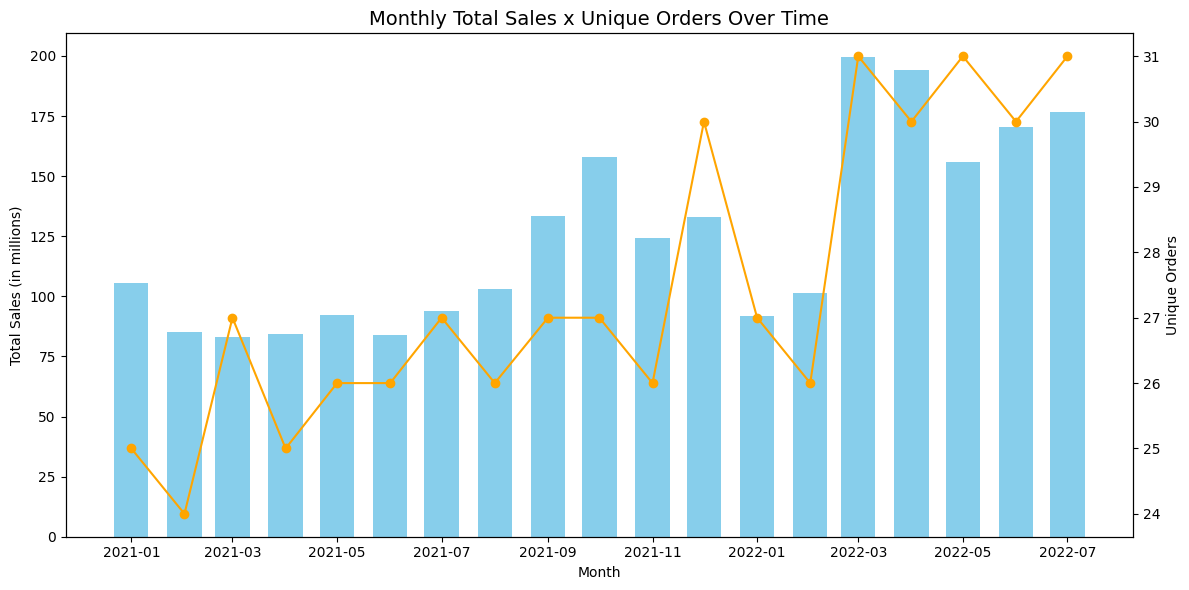

In [ ]:
historical_orders['month_year'] = historical_orders['order_date'].dt.to_period('M')
monthly_orders = historical_orders.groupby('month_year').agg(
    total_sales = ('transaction_amount', 'sum'),
    unique_orders = ('order_date', 'nunique')
).reset_index()
monthly_orders['month_year'] = monthly_orders['month_year'].dt.to_timestamp()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title('Monthly Total Sales x Unique Orders Over Time', fontsize=14)
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Sales')
ax1.bar(monthly_orders['month_year'], monthly_orders['total_sales']/ 1e6, color='skyblue', width=20, label='Total Sales')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Unique Orders')
ax2.plot(monthly_orders['month_year'], monthly_orders['unique_orders'], color='orange', marker='o', label='Unique Orders')
ax2.tick_params(axis='y')
fig.tight_layout()
plt.show()


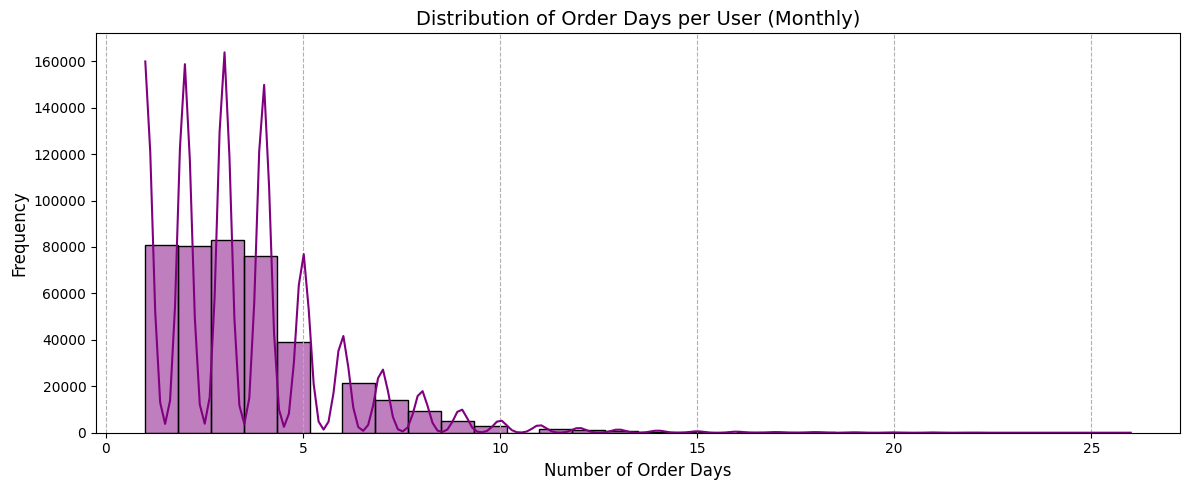

In [24]:
order_days_per_user_month = historical_orders.groupby(
    ['account_id', pd.Grouper(key='order_date', freq='ME')]
).agg(
    order_days = ('order_date', 'nunique')
).reset_index()

plt.figure(figsize=(12, 5))
sns.histplot(order_days_per_user_month['order_days'], bins=30, kde=True, color='purple')
plt.title('Distribution of Order Days per User (Monthly)', fontsize=14)
plt.xlabel('Number of Order Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

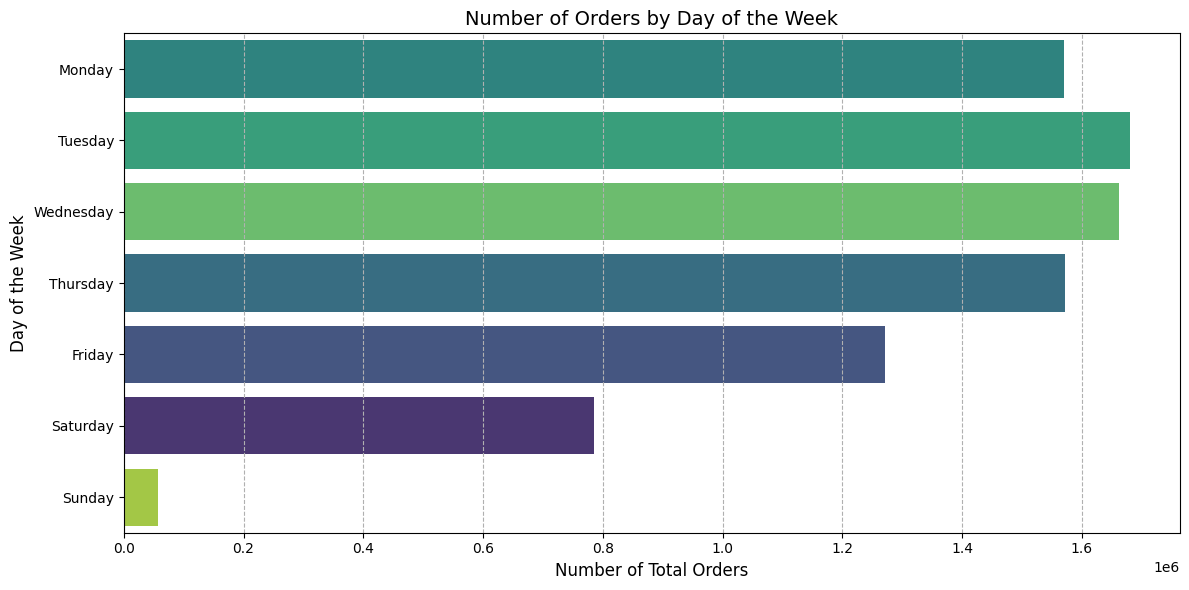

In [ ]:
historical_orders['day_of_week'] = historical_orders['order_date'].dt.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 5))
sns.countplot(y=historical_orders['day_of_week'], order=day_order, palette='viridis', hue=historical_orders['day_of_week'], legend=False)
plt.title('Number of Orders by Day of the Week', fontsize=14)
plt.xlabel('Number of Total Orders', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

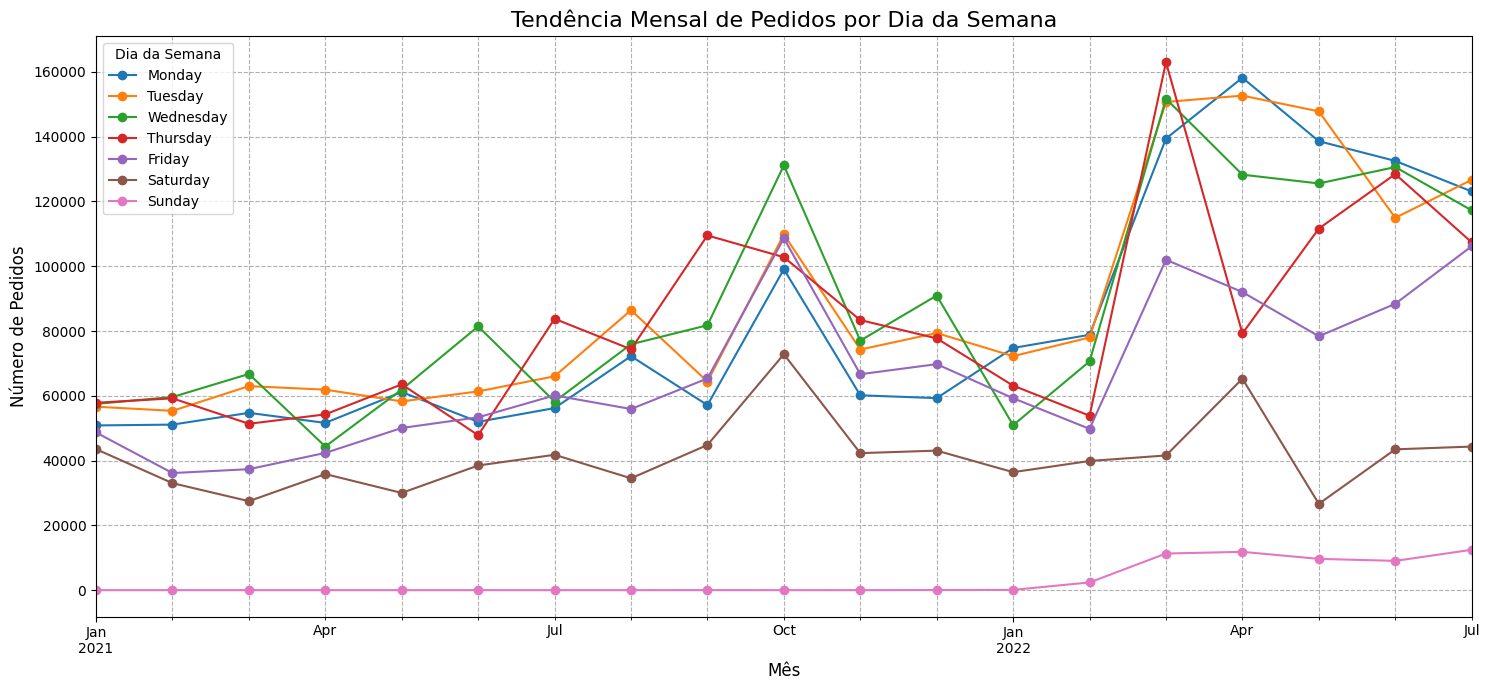

In [27]:
historical_orders['month_year'] = historical_orders['order_date'].dt.to_period('M')

orders_by_day_month = historical_orders.groupby(['month_year', 'day_of_week']).size().reset_index(name='order_count')

pivot_orders = orders_by_day_month.pivot(index='month_year', columns='day_of_week', values='order_count').fillna(0)
pivot_orders.index = pivot_orders.index.to_timestamp()
pivot_orders = pivot_orders[day_order]

pivot_orders.plot(figsize=(15, 7), marker='o', linestyle='-')
plt.title('Tendência Mensal de Pedidos por Dia da Semana', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Número de Pedidos', fontsize=12)
plt.grid(True, which='both', linestyle='--')
plt.legend(title='Dia da Semana')
plt.tight_layout()

### 2. Feature Engineering

